### IMPORTS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Reading data

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 0

tf.random.set_seed(SEED)

directory = '/kaggle/input/alzheimer-mri-dataset/Dataset'

train_dataset = image_dataset_from_directory(directory=directory,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

full_validation_dataset = image_dataset_from_directory(directory=directory,
                                                       label_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Splitting validation and testing datasets

<h4> As we see, the number of full_validation_dataset batches is 40 batch.  </h4>
<h4> And we want to split it into validation and testing datasets each of size 20 batch. </h4>

In [4]:
validation_batches = len(full_validation_dataset)
print(f'Total number of full_validation_dataset batches : {validation_batches}')

validation_dataset = full_validation_dataset.take(validation_batches // 2)
test_dataset = full_validation_dataset.skip(validation_batches // 2)

print(f'Number of batches in validation dataset : {len(validation_dataset)}')
print(f'Number of batches in test dataset : {len(test_dataset)}')

Total number of full_validation_dataset batches : 40
Number of batches in validation dataset : 20
Number of batches in test dataset : 20


In [5]:
class_names = train_dataset.class_names
class_names

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

## Exploring some samples

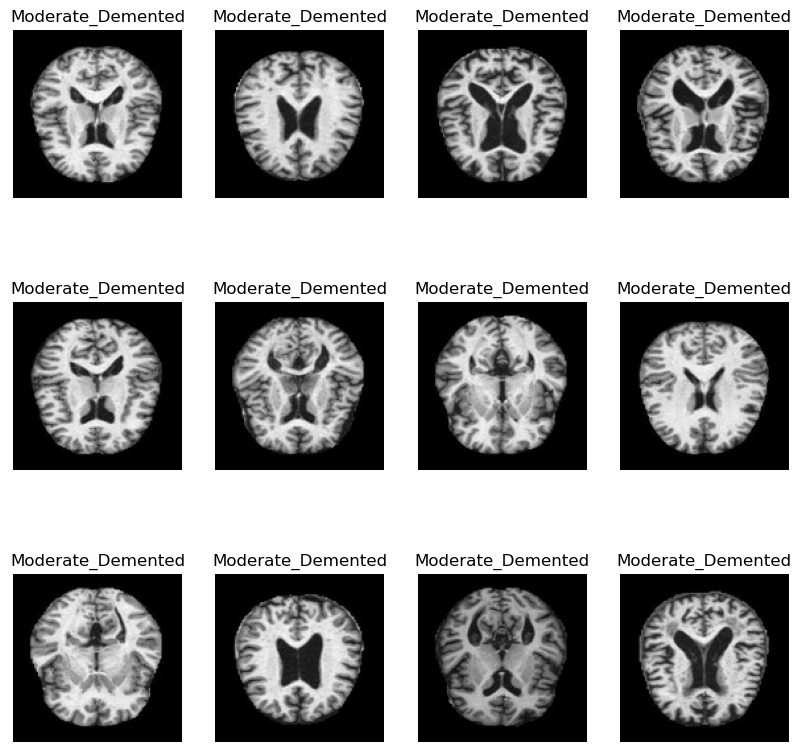

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis('off')

## Preventing a memory bottleneck
<h4> prefetch() function is used to prevent a memory bottleneck that can occur when reading from disk.</h4>
<h4> we use <b>tensorflow.data.experimental.AUTOTUNE</b> to choose the parameters automatically. </h4>

In [7]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [8]:
def data_augmentar():
    """This function applies two data augmentation techniques.
        First, augmentation with RandomRotation.
        Second, augmentation with RandomZoom
    """
    
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [9]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

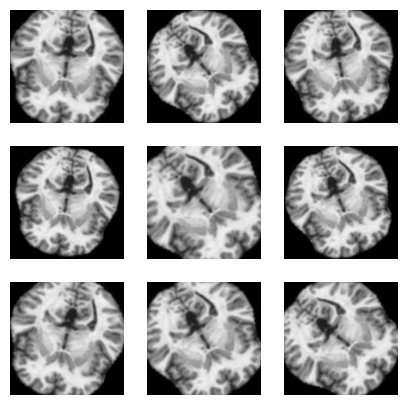

In [10]:
## applying data augmentation with a sample image.

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

## Solving Imbalanced Data Problem

In [11]:
## Calculate number of samples in each class.

class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(directory+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

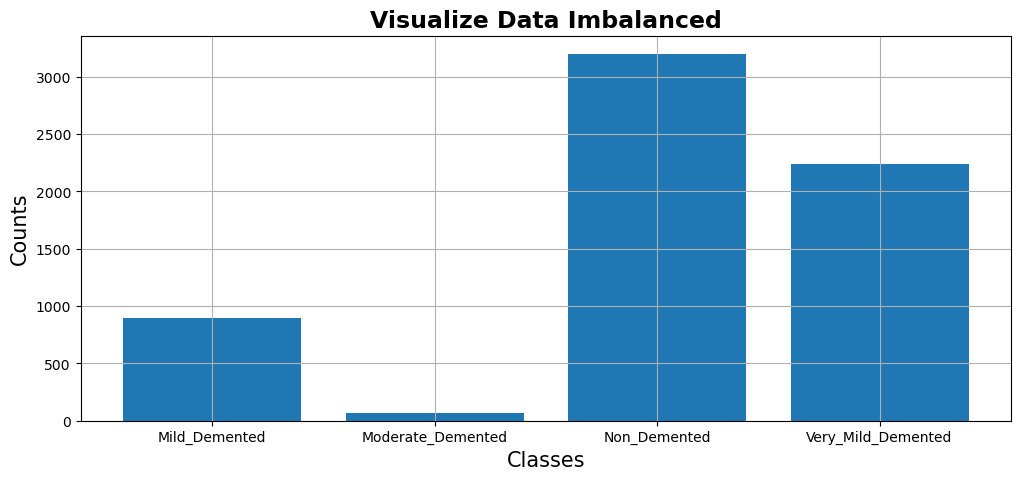

In [12]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [13]:
## Calculate class weights.

total = sum(class_counts.values())
number_of_classes = len(class_counts)

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


### EfficientNetB0

In [14]:
preprocess_input = applications.efficientnet.preprocess_input

In [15]:
model = applications.EfficientNetB0(include_top=False)
len(model.layers)

16705208/16705208 [==============================] - 0s 0us/step


238

In [16]:
def alzheimer_classifier(image_shape=IMG_SIZE, data_augmentation=data_augmentar()):
    """This function creates a classifier for Alzheimer disease MRI images.
    
    Arguments:
        image_shape-> the size of the image in the form (height, width).
        data_augmentation-> the data augmentation object to apply on the training data.
        
    Returns:
        model-> the created classifier.
    """
    IMG_SHAPE = image_shape + (3,)
    base_model = applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                             include_top=False, 
                                             weights='imagenet')
    
    base_model.trainable = True
    for layer in base_model.layers[0:218]:
        layer.trainable = False
    
    inputs = Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=4, activation = "softmax")(x)
    
    model = Model(inputs, outputs)
    
    return model

In [17]:
alzheimer_model = alzheimer_classifier(IMG_SIZE, data_augmentation)

In [18]:
alzheimer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 1,356,084
Non-trainable params: 2,698,611
_________________________________________________________________


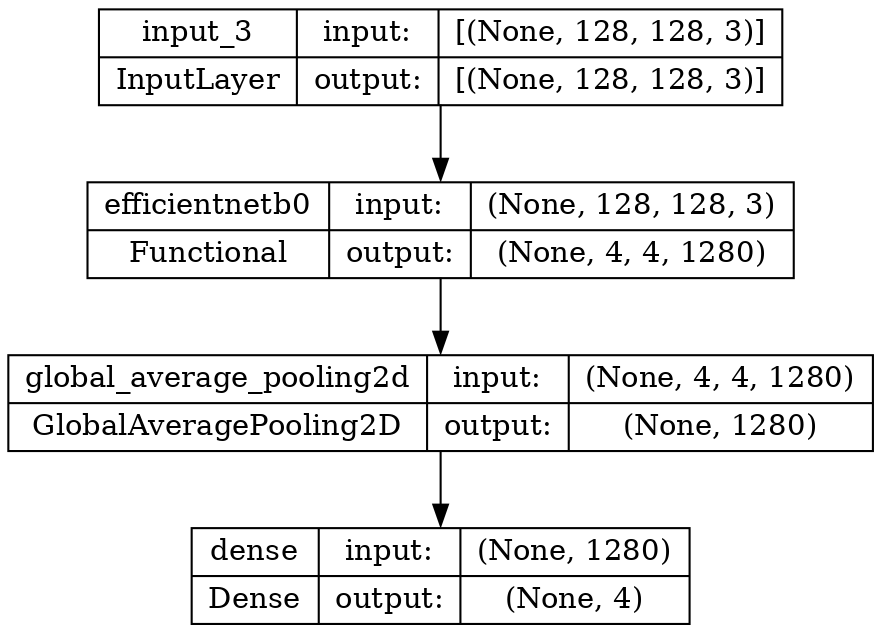

In [19]:
tf.keras.utils.plot_model(alzheimer_model, show_shapes=True, dpi=150)

In [20]:
lr = 0.001
alzheimer_model.compile(loss=CategoricalCrossentropy(),
                        optimizer=Adam(learning_rate=lr),
                        metrics=['accuracy',
                                tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),])

In [21]:
# filepath = './effnet_best_weights.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
# checkpoint    = ModelCheckpoint(filepath, 
#                                 monitor = 'val_accuracy', 
#                                 mode='max', 
#                                 save_best_only=True, 
#                                 verbose = 1)


callback_list = [earlystopping]

### MODEL TRAINING

In [22]:
history = alzheimer_model.fit(train_dataset, 
                              validation_data = validation_dataset,
                              epochs = 50,
                              class_weight=class_weights, callbacks = callback_list,
                              use_multiprocessing=True)

Epoch 1/50
160/160 [==============================] - 113s 638ms/step - loss: 1.1883 - accuracy: 0.4459 - auc: 0.7420 - precision: 0.5279 - recall: 0.2936 - val_loss: 0.9068 - val_accuracy: 0.5719 - val_auc: 0.8465 - val_precision: 0.6373 - val_recall: 0.4750
Epoch 2/50
160/160 [==============================] - 100s 625ms/step - loss: 0.7868 - accuracy: 0.5721 - auc: 0.8389 - precision: 0.6457 - recall: 0.4484 - val_loss: 0.8408 - val_accuracy: 0.6422 - val_auc: 0.8800 - val_precision: 0.6615 - val_recall: 0.6016
Epoch 3/50
160/160 [==============================] - 101s 629ms/step - loss: 0.6171 - accuracy: 0.6430 - auc: 0.8878 - precision: 0.7009 - recall: 0.5594 - val_loss: 0.6401 - val_accuracy: 0.7078 - val_auc: 0.9252 - val_precision: 0.7812 - val_recall: 0.6641
Epoch 4/50
160/160 [==============================] - 101s 628ms/step - loss: 0.5498 - accuracy: 0.7031 - auc: 0.9170 - precision: 0.7532 - recall: 0.6461 - val_loss: 0.7253 - val_accuracy: 0.6984 - val_auc: 0.9107 - val

### PLOTTING RESULTS:

In [23]:
result = alzheimer_model.evaluate(test_dataset)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Test Loss = {train_loss}')
print(f'Test Accuracy = {train_accuracy}')
print(f'Test AUC = {train_AUC}')
print(f'Test Precision = {train_pre}')
print(f'Test Recall = {train_rec}')

20/20 [==============================] - 10s 480ms/step - loss: 0.1101 - accuracy: 0.9625 - auc: 0.9974 - precision: 0.9640 - recall: 0.9625
Test Loss = 0.11009451001882553
Test Accuracy = 0.9624999761581421
Test AUC = 0.9973616003990173
Test Precision = 0.964006245136261
Test Recall = 0.9624999761581421


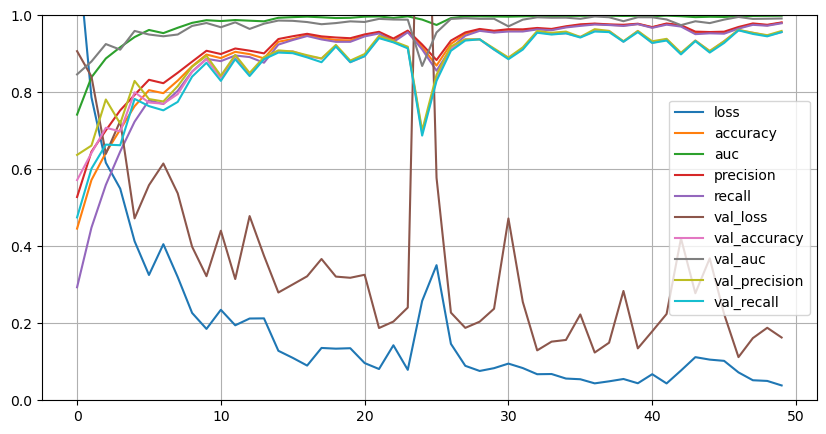

In [24]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

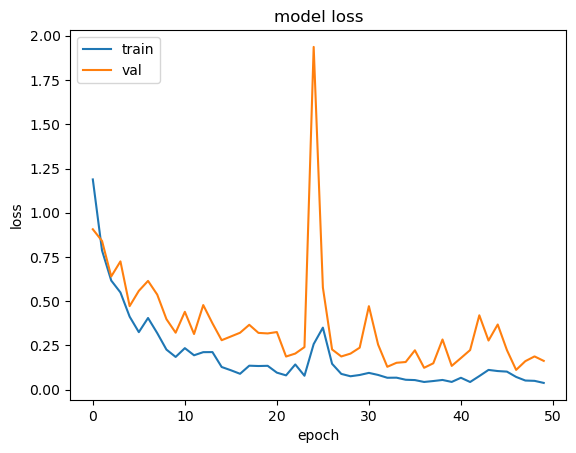

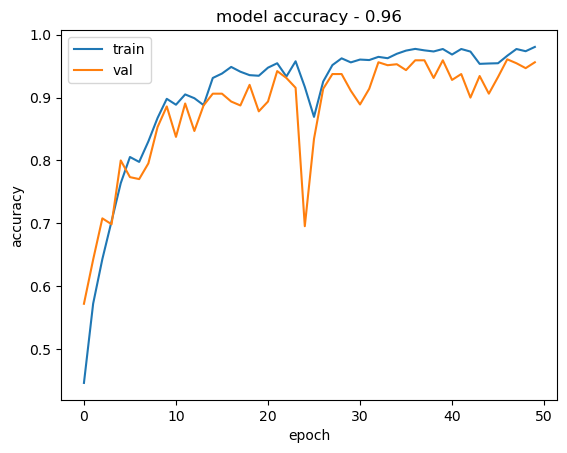

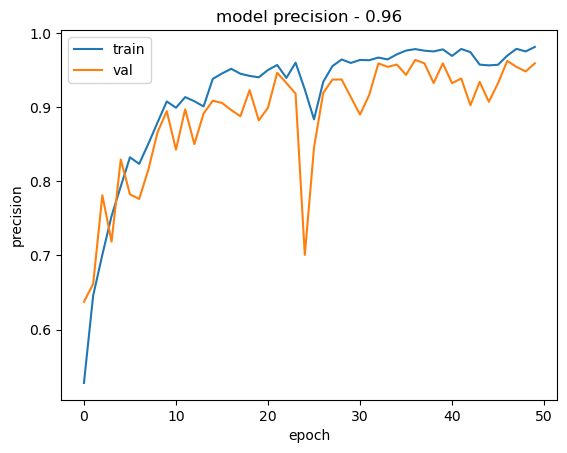

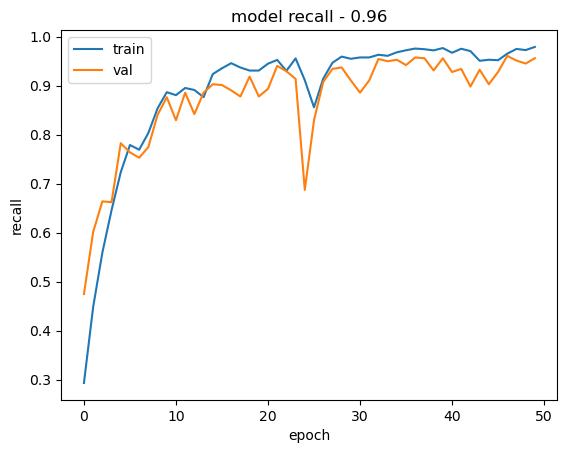

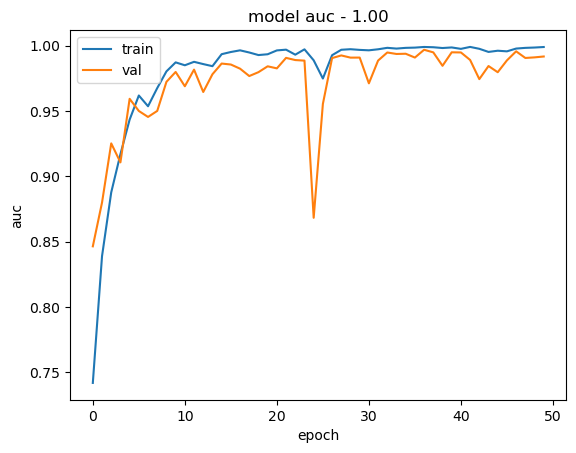

In [25]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(result[1], "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision - ' + str(format(result[3], "0.2f")))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall - ' + str(format(result[4], "0.2f")))
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc - ' + str(format(result[2], "0.2f")))
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
correct_labels.shape

(640,)

In [30]:
predicted_labels.shape

TensorShape([640])

### CONFUSION MATRIX

1/1 [==============================] - 0s 485ms/step


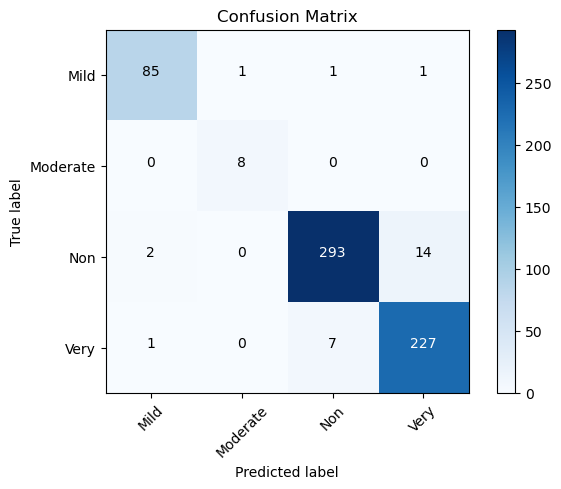

In [44]:
from itertools import product
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = alzheimer_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
confusion_mtx = confusion_matrix(correct_labels, predicted_labels)

# y_pred = alzheimer_model.predict(test_dataset)

# predicted_categories = tf.argmax(y_pred, axis=1)

# true_categories = tf.concat([y for x, y in test_dataset], axis=0)

# confusion_mtx = confusion_matrix(predicted_categories, true_categories)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()